In [1]:
import glob, os, sys, toml, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from os import path

from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor



path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import gp
import NSGA2


import os, sys, subprocess, time, toml

path_MOASMO = '/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/allbasin_emulator/'
sys.path.append(path_MOASMO)
from MOASMO_parameter_allbasin_emulator import *
from multiprocessing import Pool


sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
# import NSGA2

sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/moasmo_test")
from MOASMO_parameters import *


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Suppress UserWarning regarding Loky-backed parallel loops
warnings.filterwarnings(action='ignore', message='Loky-backed parallel loops cannot be called in a multiprocessing')

In [3]:
import os
import shutil

# List of basins (assumes you have a function or list of basin names)
Basin_list = list_folders('/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/param_sets')

# Base paths
source_base_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV'
target_base_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'

# Loop through each basin and copy the file
for basin_name in Basin_list:
    # Construct the full source and target file paths
    source_file = os.path.join(source_base_path, basin_name, 'iter0_all_meanparam.csv')
    target_dir = os.path.join(target_base_path, basin_name)
    target_file = os.path.join(target_dir, 'iter0_all_meanparam.csv')
    
    try:
        # Create target directory if it doesn't exist
        os.makedirs(target_dir, exist_ok=True)
        
        # Copy the file
        shutil.copy2(source_file, target_file)
        # print(f"Copied {source_file} to {target_file}")
        
    except Exception as e:
        print(f"Error copying file for basin {basin_name}: {e}")


Error copying file for basin 05120500: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copying file for basin 06447000: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copying file for basin 03187500: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copying file for basin 01078000: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copying file for basin 01484100: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copying file for basin 14185000: [Errno 13] Permission denied: '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_new'
Error copy

In [4]:
infile_basin_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
infile_param_info = '/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/param_file_tpl.csv'
infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
inpath_moasmo = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib'

ncpus = 1
iterend = 1
outpathname = 'LSE_spaceCV_PredictParam'
suffix = 'LSEspaceCV'
objfunc = 'normKGE'
numruns = 100
target_index = np.arange(627)

In [ ]:
#iter1

In [9]:
cv_num = 5
    
outpath = f"{inpath_moasmo}/{outpathname}"
os.makedirs(outpath, exist_ok=True)

# Load data: same for all iterations
df_basin_info = pd.read_csv(infile_basin_info)
df_basin_info.index = np.arange(len(df_basin_info))
all_index = np.arange(len(df_basin_info))

# divide into train/test index
outfile = f'{outpath}/train_test_CV_indices.npz'
if os.path.isfile(outfile):
    dtmp = np.load(outfile, allow_pickle=True)
    train_indices, test_indices = dtmp['train_indices'], dtmp['test_indices']
else:
    train_indices = []
    test_indices = []
    for i in range(cv_num):
        ind1 = all_index[i::cv_num]
        ind2 = np.setdiff1d(all_index, ind1)
        test_indices.append(ind1)
        train_indices.append(ind2)
        print('test index', ind1)
        print('train index', ind2)
    np.savez_compressed(outfile, test_indices=np.array(test_indices, dtype=object), train_indices=np.array(train_indices, dtype=object))

# information for all basins
df_param_info = pd.read_csv(infile_param_info)

file_defa_param = f'{outpath}/camels_{len(all_index)}basin_summa_defa_param.csv'
df_param_defa = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, all_index)

df_param_defa['basin_id'] = df_param_defa['basin_id'].astype(str).apply(lambda x: x.zfill(8))

file_param_lb = f'{outpath}/camels_{len(all_index)}basin_summa_all_param_lb.gz'
file_param_ub = f'{outpath}/camels_{len(all_index)}basin_summa_all_param_ub.gz'
df_param_lb, df_param_ub = load_basin_param_bounds(inpath_moasmo, df_param_defa, file_param_lb, file_param_ub)


file_camels_attribute = f'{outpath}/camels_{len(all_index)}basin_attribute.pkl'
df_att = read_camels_attributes(infile_basin_info, file_camels_attribute, all_index)


df_att_foruse = pd.read_csv(infile_attr_foruse)
useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
print("The number of attributes used:", len(useattrs))
print(useattrs)

# Load data: outputs from each iteration
for iter in range(0, iterend):

    file_all_param = f'{outpath}/camels_{len(all_index)}basin_summa_all_param_iter{iter}.gz'
    file_all_metric = f'{outpath}/camels_{len(all_index)}basin_summa_all_metric_iter{iter}.gz'
    file_all_basinid = f'{outpath}/camels_{len(all_index)}basin_summa_all_basinid_iter{iter}.gz'

    df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa, df_basin_info, iter, file_all_param, file_all_metric, file_all_basinid, np.arange(len(df_basin_info)), suffix)


    
    df_basinid_i['iter'] = iter
    
    if iter == 0:
        df_param = df_param_i
        df_metric = df_metric_i
        df_basinid = df_basinid_i
    else:
        df_param = pd.concat([df_param, df_param_i])
        df_metric = pd.concat([df_metric, df_metric_i])
        df_basinid = pd.concat([df_basinid, df_basinid_i])

df_param = df_param.apply(pd.to_numeric, errors='coerce')

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

index = np.isnan(np.sum(df_metric.values, axis=1) + np.sum(df_param.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))

# Prepare model input and output
df_input = df_param.copy()
df_input["hru_id"] = df_basinid["basin_name"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs

# One-hot encoding for categorical attributes
for att in useattrs:
        if df_input[att].dtype == "object":
            print('Convert', att, 'to one-hot encoding')
            enc = OneHotEncoder(sparse=False)
            enc.fit(df_input[[att]])
            encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
            print('New columns:', encnames)
            df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
            df_input = pd.concat([df_input, df_enc], axis=1)
            df_input = df_input.drop([att], axis=1)
            inputnames = [i for i in inputnames if i != att] + encnames


x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)




File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam/camels_627basin_attribute.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 883
Number of original parameter sets: 250800
Number of final parameter sets: 249917
Convert dom_land_cover to one-hot encoding
New columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3', 'dom_land_cover_4', 'dom_land_cover_5', 'dom_land_cover_6', 'dom_land_cover_7', 'dom_land_cover_8', 'dom_land_cover_9', 'dom_land_cover_10', 'dom_lan

/glade/work/guoqiang/conda-envs/npl-2024a-tgq/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Input shape: (249917, 52)


In [10]:

for cvind in range(len(train_indices)):
    train_index = train_indices[cvind]
    test_index = test_indices[cvind]

    train_index_allsample = df_basinid['basin_num'].isin(train_index).values
    test_index_allsample = df_basinid['basin_num'].isin(test_index).values

    # Debugging prints to verify the number of selected samples
    print('Train/test model')
    print('Train index:', train_index)
    print('Test index:', test_index)
    print(f"Number of training samples: {np.sum(train_index_allsample)}")
    print(f"Number of testing samples: {np.sum(test_index_allsample)}")

    if objfunc == 'normKGE':
        print('Use normalized KGE as output')
        df_output = df_metric.copy()
        y_all = df_output[["kge"]].values.copy()
        y_all = y_all / (2 - y_all)  # Normalize KGE
    
    #     # Train a random forest emulator
    #     outfile = f'{outpath}/RF_emulator_for_iter{iterend}_CVFold{cvind}.pkl'
    #     outfile_eval = f'{outpath}/RF_emulator_for_iter{iterend}_CVFold{cvind}_eval.npz'
    #     if os.path.isfile(outfile):
    #         with open(outfile, 'rb') as file:
    #             em_model = pickle.load(file)
    #     else:
    #         modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    #         em_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
    #         em_model.fit(x_all[train_index_allsample], y_all[train_index_allsample])
    #         with open(outfile, 'wb') as file:
    #             pickle.dump(em_model, file)

    #         # Evaluate the model on testing samples
    #         y_test_pred = em_model.predict(x_all[test_index_allsample])
    #         np.savez_compressed(outfile_eval, 
    #                             y_test_pred=y_test_pred, 
    #                             y_test=y_all[test_index_allsample], 
    #                             basin_id=df_basinid['basin_num'].values[test_index_allsample]) 

    # elif objfunc == 'norm2err':
    #     print('Use normalized MAE and MMAE as output')
    #     df_output = df_metric.copy()
    #     metvalues = df_output[['mae', 'max_mon_abs_err']].values.copy()
    #     y_all = np.nan * metvalues
    #     for i in range(len(df_basin_info)):
    #         indi = df_basinid['basin_id'].values == i
    #         di = metvalues[indi, :]
    #         di = (di - np.nanmin(di, axis=0)) / (np.nanmax(di, axis=0) - np.nanmin(di, axis=0))
    #         y_all[indi, :] = di
        
    #     # Train a random forest emulator
    #     outfile = f'{outpath}/RF_emulator_2errOBJfunc_for_iter{iterend}_CVFold{cvind}.pkl'
    #     outfile_eval = f'{outpath}/RF_emulator_2errOBJfunc_for_iter{iterend}_CVFold{cvind}_eval.npz'
    #     if os.path.isfile(outfile):
    #         with open(outfile, 'rb') as file:
    #             em_model = pickle.load(file)
    #     else:
    #         modelconfig = {'n_estimators': 200, 'random_state': 42, 'max_depth': 40}
    #         em_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
    #         em_model.fit(x_all[train_index_allsample], y_all[train_index_allsample])
    #         with open(outfile, 'wb') as file:
    #             pickle.dump(em_model, file)

    #         # Evaluate the model on testing samples
    #         y_test_pred = em_model.predict(x_all[test_index_allsample])
    #         np.savez_compressed(outfile_eval, 
    #                             y_test_pred=y_test_pred, 
    #                             y_test=y_all[test_index_allsample], 
    #                             basin_id=df_basinid['basin_id'].values[test_index_allsample])

    # # Pass the necessary parameters for parallel processing of basins
    # param_names = df_param_info['Parameter'].values
    # parallel_process_basins(
    #     df_basinid[test_index_allsample], 
    #     df_param_lb.iloc[test_index], 
    #     df_param_ub.iloc[test_index], 
    #     x_all[test_index_allsample], 
    #     df_input[test_index_allsample], 
    #     y_all[test_index_allsample], 
    #     param_names, 
    #     inputnames, 
    #     em_model, 
    #     inpath_moasmo, 
    #     ncpus, 
    #     numruns, 
    #     iterend, 
    #     test_index, 
    #     suffix
    # )


    break

Train/test model
Train index: [  1   2   3   4   6   7   8   9  11  12  13  14  16  17  18  19  21  22
  23  24  26  27  28  29  31  32  33  34  36  37  38  39  41  42  43  44
  46  47  48  49  51  52  53  54  56  57  58  59  61  62  63  64  66  67
  68  69  71  72  73  74  76  77  78  79  81  82  83  84  86  87  88  89
  91  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 111 112
 113 114 116 117 118 119 121 122 123 124 126 127 128 129 131 132 133 134
 136 137 138 139 141 142 143 144 146 147 148 149 151 152 153 154 156 157
 158 159 161 162 163 164 166 167 168 169 171 172 173 174 176 177 178 179
 181 182 183 184 186 187 188 189 191 192 193 194 196 197 198 199 201 202
 203 204 206 207 208 209 211 212 213 214 216 217 218 219 221 222 223 224
 226 227 228 229 231 232 233 234 236 237 238 239 241 242 243 244 246 247
 248 249 251 252 253 254 256 257 258 259 261 262 263 264 266 267 268 269
 271 272 273 274 276 277 278 279 281 282 283 284 286 287 288 289 291 292
 293 294 296 297 298 

In [14]:
x_all[:,0]

array([2.72459100e-05, 8.14162623e-04, 8.27784216e-04, ...,
       3.42278563e-03, 2.60155600e-03, 3.99515779e-03])

In [19]:
df_input.loc[train_index_allsample]

,k_soil,theta_sat,aquiferBaseflowExp,aquiferBaseflowRate,qSurfScale,summerLAI,frozenPrecipMultip,routingGammaScale,routingGammaShape,Fcapil,...,dom_land_cover_2,dom_land_cover_3,dom_land_cover_4,dom_land_cover_5,dom_land_cover_6,dom_land_cover_7,dom_land_cover_8,dom_land_cover_9,dom_land_cover_10,dom_land_cover_11
400,0.000086,0.383211,1.145149,0.091423,12.62701,0.572141,1.359971,18751.89,3.224789,0.010003,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
401,0.004782,0.411131,1.273750,0.093132,18.64625,1.033787,2.387500,1973.25,3.865000,0.059626,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
402,0.005819,0.538725,2.511250,0.017707,1.40375,0.857853,1.602500,34668.45,4.305000,0.025539,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
403,0.001458,0.583105,3.493750,0.070654,2.68625,0.465222,1.642500,53382.15,1.575000,0.078816,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
404,0.007653,0.698019,1.686250,0.062163,19.64375,0.433039,0.817500,36389.25,2.055000,0.071999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249912,0.000909,0.550266,2.961250,0.090634,14.51375,3.899824,1.487500,31441.95,2.615000,0.081594,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
249913,0.009520,0.582641,3.186250,0.098377,10.14375,3.257437,1.077500,25419.15,1.475000,0.014934,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
249914,0.003423,0.615915,3.748750,0.049925,10.80875,6.646027,1.582500,60695.55,3.995000,0.105834,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
249915,0.002602,0.637499,2.203750,0.016708,13.18375,5.602149,0.817500,6275.25,3.605000,0.019731,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
np.nanmean(x_all[train_index_allsample,:],axis=0)

array([ 1.04066783e-03,  5.27079950e-01,  2.50126462e+00,  5.00835275e-02,
        1.05058256e+01,  5.61682173e+00,  1.49850362e+00,  4.33941754e+04,
        3.00020215e+00,  5.94208603e-02,  2.73160003e+02,  9.99674529e+00,
        5.24424022e-01,  2.64735398e+00,  7.56228224e+02,  4.64816192e+01,
        5.92053329e+02,  3.27620714e+00,  2.79124271e+00,  1.05116774e+00,
       -6.05206623e-02,  1.77158919e-01,  2.09576482e+01,  1.35170999e+00,
        2.54723325e+02,  5.97412233e+00,  6.44993854e-01,  3.22607349e+00,
        2.45015768e+00,  8.04969774e-01,  1.07238460e+01,  1.28901177e+00,
        4.42707056e-01,  1.74819642e+00,  5.29161200e-01,  3.66935777e+01,
        3.39305441e+01,  2.00183139e+01,  1.20645495e-01, -1.38854000e+01,
        2.00006000e-03,  4.00012000e-03,  9.79779393e-02,  1.78005340e-01,
        6.00018001e-03,  1.60004800e-01,  1.56004680e-01,  1.30003900e-01,
        1.60004800e-02,  6.00018001e-03,  1.05998180e-01,  1.38004140e-01])

In [28]:
x_all[train_index_allsample,:]

array([[ 0.46617423],
       [-0.1175955 ],
       [ 0.20176755],
       ...,
       [ 0.38260224],
       [ 0.52083463],
       [ 0.41121676]])

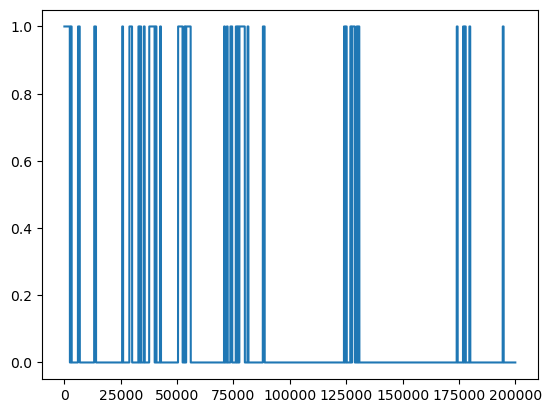

In [31]:
plt.plot(x_all[train_index_allsample,-5])

In [49]:
att = []
for i in test_index:
    indi = df_basinid[test_index_allsample]['basin_num'].values == i
    di = x_all[test_index_allsample,14:][indi,:]
    att.append(di[0,:])


IndexError: index 0 is out of bounds for axis 0 with size 0

In [65]:
    i=0
    indi = df_basinid[test_index_allsample]['basin_num'].values == i
    di = x_all[test_index_allsample,14:][indi,:]
    di[0]

array([ 2.50310000e+02,  2.16415200e+01,  2.25270000e+03,  3.12667899e+00,
        1.97155451e+00,  6.30558659e-01,  1.87940259e-01,  3.13440357e-01,
        1.29500000e+01,  1.34895833e+00,  2.02200000e+02,  3.42711864e+00,
        9.06300000e-01,  4.16730395e+00,  3.34073186e+00,  8.83451919e-01,
        7.40476190e+00,  1.24840792e+00,  4.61148751e-01,  1.10652248e+00,
        5.58054827e-01,  2.78418273e+01,  5.51569400e+01,  1.62757317e+01,
        0.00000000e+00, -1.47019000e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [69]:
df_input[df_basinid['basin_num']==0].values[0,14:]

array([ 2.50310000e+02,  2.16415200e+01,  2.25270000e+03,  3.12667899e+00,
        1.97155451e+00,  6.30558659e-01,  1.87940259e-01,  3.13440357e-01,
        1.29500000e+01,  1.34895833e+00,  2.02200000e+02,  3.42711864e+00,
        9.06300000e-01,  4.16730395e+00,  3.34073186e+00,  8.83451919e-01,
        7.40476190e+00,  1.24840792e+00,  4.61148751e-01,  1.10652248e+00,
        5.58054827e-01,  2.78418273e+01,  5.51569400e+01,  1.62757317e+01,
        0.00000000e+00, -1.47019000e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [72]:
df_att['mean_elev']

0      250.31
1       92.68
2      143.80
3      247.80
4      310.38
        ...  
622    709.83
623    952.26
624    656.53
625    875.67
626    625.31
Name: mean_elev, Length: 627, dtype: float64

In [73]:
x_all

array([[2.72459100e-05, 4.24316900e-01, 1.90272900e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.14162623e-04, 3.67674046e-01, 3.98875000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.27784216e-04, 6.41200519e-01, 2.27125000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.42278563e-03, 6.15915376e-01, 3.74875000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.60155600e-03, 6.37498595e-01, 2.20375000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.99515779e-03, 3.50621644e-01, 3.79375000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])